### Lidar point

In [6]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.cluster import DBSCAN
import cv2
from sklearn.linear_model import LinearRegression
import time

data = np.load('data.npy', allow_pickle=True)
X = []
rads = np.linspace(0,2*np.pi,1972)
limit = 10.0
for i,rad in enumerate(rads):
    if data[i] < limit:
        # X.append([data[i], rad])
        X.append([data[i]*np.cos(rad), data[i]*np.sin(rad)])
X = np.array(X)
X.shape

(946, 2)

0.0037021636962890625


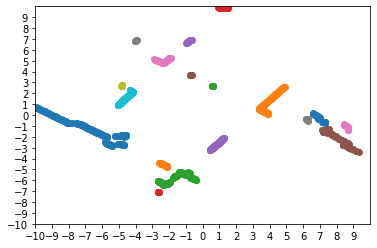

In [7]:
t1 = time.time()
clus = DBSCAN(eps=0.5, min_samples=5).fit(X).labels_ 
print(time.time() -t1)
fig, ax = plt.subplots()
ax.set(xlim=(-limit,limit), xticks=np.arange(-limit,limit),
       ylim=(-limit,limit), yticks=np.arange(-limit,limit))
for id in set(clus):
    Xi = X[np.where(clus==id)]
    ax.scatter(Xi[:,0], Xi[:,1])
plt.show()

0.016116619110107422


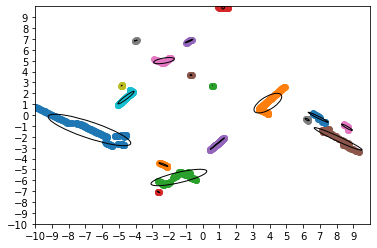

In [10]:
def find_hull(xy, scale=100, lim=400):
    xy_ = np.int32(xy*scale)+lim
    img = np.zeros((2*lim,2*lim)).astype(np.uint8)
    img[xy_[:,1], xy_[:,0]] = 255
    # img = cv2.flip(img, 0)

    kernel = np.ones((5,5))
    img = cv2.dilate(img, kernel, iterations=1)
    kernel = np.ones((3,3))
    img = cv2.erode(img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        print('num of contour', len(contours))
    # img_show = cv2.drawContours(img.copy(), contours, -1, 255, 3)
    hull = cv2.convexHull(contours[0])
    # img_show = cv2.drawContours(img.copy(), [hull], -1, 255, 3)
    hull = hull.reshape((-1,2))
    hull = (hull-lim)/scale
    return hull

def find_circle(xy):
    center = np.mean(xy, axis=0)
    dist = np.linalg.norm(xy-center, axis=1)
    r = np.max(dist)
    return center, r

def hull2ellipse(hull, n_std=2.0):
    cov = np.cov(hull[:,0], hull[:,1])
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)*np.sqrt(cov[0, 0]) * n_std
    ell_radius_y = np.sqrt(1 - pearson)*np.sqrt(cov[1, 1]) * n_std

    w,v = np.linalg.eig(cov)
    vmax = v[np.argmin(w)]
    rot = np.rad2deg(np.arctan2(vmax, [1,0])[0])
    if rot < 0:
        rot += 90
    ellipse = Ellipse(np.mean(hull, axis=0), width=ell_radius_x * 2, height=ell_radius_y * 2, fill=False, angle=rot)
    return ellipse

fig, ax = plt.subplots()
# ax.set(xlim=(-4,4), xticks=np.arange(-4,4),
#         ylim=(-4,4), yticks=np.arange(-4,4))

ax.set(xlim=(-limit,limit), xticks=np.arange(-limit,limit),
       ylim=(-limit,limit), yticks=np.arange(-limit,limit))

# ax.set(xlim=(2,0), xticks=np.arange(0,2),
#         ylim=(-1,-4), yticks=np.arange(-1,-4))

t1 = time.time()
for i in set(clus):
    xy = X[np.where(clus==i)]
    ax.scatter(xy[:,0], xy[:,1])
    ellipse = hull2ellipse(xy, n_std=2.0)
    ax.add_patch(ellipse)
    # break
print(time.time() - t1)
plt.show()